In [56]:
%load_ext autoreload
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
from datetime import datetime
import os
import shutil
import argparse
import time
import json
from collections import defaultdict
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.parallel import DistributedDataParallel
from tqdm import tqdm
from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import video_comparison

import torchio as tio

from celluloid import Camera
from IPython.core.display import HTML
from train import DiceScoreBinary, CatBrainMaskLoader, create_datesets, DiceLossBinary
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
MAKE_LOGS = False
SAVE_MODEL = False
DEVICE = 1
plt.rcParams['font.size'] = 20

In [7]:
logdir = 'logs/v2v_whole_s128_bs1_GN_trim_DICE_TSC_AUG@07.12.2021-00:48:11/'

# Load model, setup dataloaders

In [8]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

device = torch.device(DEVICE)

writer = None
model = V2VModel(config).to(device)
print('Model created!')

# setting datasets
train_dataset, val_dataset = create_datesets(config)
train_dataloader = DataLoader(train_dataset, batch_size=config.opt.train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.opt.val_batch_size, shuffle=False)

# setting model stuff
criterion = {
    "CE": torch.nn.CrossEntropyLoss(),
    "BCE": torch.nn.BCELoss(),
    "Dice": None
}[config.opt.criterion]

model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights.pth'))
print('LOADING from epoch:',model_dict['epoch'])
print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))
model.load_state_dict(model_dict['model_state'])

Model created!
LOADING from epoch: 69


<All keys matched successfully>

# Forward pass

In [23]:
brain_tensors = []
predicted_masks = []
real_masks = []
dices = []

iterator = enumerate(val_dataloader)

for iter_i, (brain_tensor, mask_tensor) in tqdm(iterator):
    
    # prepare
    brain_tensor = brain_tensor # [bs,1,ps,ps,ps]
    mask_tensor = mask_tensor # [bs,ps,ps,ps]

    if config.interpolate:
        brain_tensor = F.interpolate(brain_tensor, config.interpolation_size).to(device)
        mask_tensor = F.interpolate(mask_tensor, config.interpolation_size).to(device) 
    else:
        brain_tensor = brain_tensor.to(device)
        mask_tensor = mask_tensor.to(device)

    # forward pass
    mask_tensor_predicted = model(brain_tensor) # [bs,2,ps,ps,ps]
    
    dice_score = DiceScoreBinary(mask_tensor_predicted.detach().cpu(), mask_tensor.detach().cpu())
    dices.append(dice_score.item())
    
    assert brain_tensor.shape[0] == 1
    mask_tensor_sample = mask_tensor.detach().cpu().numpy()[0,0] 
    brain_tensor_sample = brain_tensor.detach().cpu().numpy()[0,0]
    mask_tensor_predicted_sample = mask_tensor_predicted.detach().cpu().numpy()[0,0]
    
    # crucial for freein CUDA memory
    del mask_tensor_predicted, mask_tensor

    brain_tensors.append(brain_tensor_sample)
    predicted_masks.append(mask_tensor_predicted_sample)
    real_masks.append(mask_tensor_sample)
    
    torch.cuda.empty_cache()
    
#     break

0it [00:00, ?it/s]

torch.Size([1, 4, 128, 128, 128])


1it [00:01,  1.68s/it]

torch.Size([1, 4, 128, 128, 128])


2it [00:05,  3.04s/it]

torch.Size([1, 4, 128, 128, 128])


3it [00:07,  2.47s/it]

torch.Size([1, 4, 128, 128, 128])


4it [00:11,  3.10s/it]

torch.Size([1, 4, 128, 128, 128])


5it [00:15,  3.32s/it]

torch.Size([1, 4, 128, 128, 128])


6it [00:19,  3.67s/it]

torch.Size([1, 4, 128, 128, 128])


7it [00:24,  4.13s/it]

torch.Size([1, 4, 128, 128, 128])


8it [00:26,  3.31s/it]


In [35]:
val_labels = val_dataloader.dataset.labels

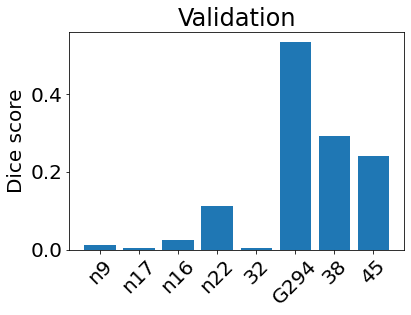

In [50]:
plt.bar(val_labels, dices)
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.show()

In [51]:
exp_name

'v2v_whole_s128_bs1_GN_trim_DICE_TSC_AUG@07.12.2021-00:48:11'

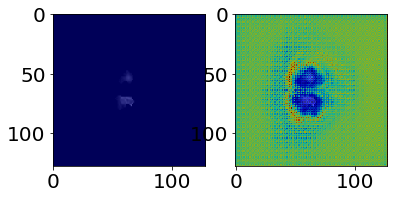

In [52]:
ind = np.argmax(dices)
plt.ioff()
camera = video_comparison([brain_tensors[ind], brain_tensors[ind]], 
                          [real_masks[ind],predicted_masks[ind]], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Check geom. features concordance

In [53]:
brain_tensor_ = brain_tensor[0].detach().cpu().numpy()

In [22]:
plt.ioff()
camera = video_comparison(brain_tensor_, 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Check augmentation

In [62]:
brain_tensor_ = brain_tensor[0].detach().cpu().numpy()

symmetry = tio.RandomFlip(axes=0)
bias = tio.RandomBiasField(coefficients=0.3)
noise = tio.RandomNoise(std=(0,1e-3))
affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
                         degrees=15,
                         translation=(1,1,1),
                         center='image',
                         default_pad_value=0)
rescale = tio.RescaleIntensity(out_min_max=(0, 1))
augmentation = tio.Compose([symmetry, bias, noise, affine, rescale]) # , affine

subject = tio.Subject(
            t1=tio.ScalarImage(tensor=brain_tensor_),
            diagnosis='positive'
        )

transformed = augmentation(subject)
brain_tensor_transformed = transformed['t1'].tensor.numpy()

In [88]:
# plt.imshow(brain_tensor_transformed[1,:,10,:])
# plt.colorbar()

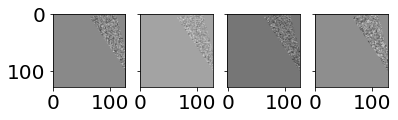

In [75]:
plt.ioff()
camera = video_comparison(brain_tensor_transformed)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation